#### 1) 데이터 불러오기

In [ ]:
# 하이퍼 파라미터 설정
class Parameters():
    def __init__(self):
        self.description = 'Convolutional Neural Network for Image Classification'
        # 에포크 수
        self.epochs = 50
        # 배치 크기
        self.batch_size = 16
        # 학습률
        self.learning_rate = 1e-4 # 0.0001
        # 훈련된 모델 경로
        self.model_name = 'CNN'
        # 파일명
        self.data_path = './Datasets/Wafermap'
args = Parameters()

In [ ]:
import os
import random
import torch
import numpy as np
# 시드(seed) 고정
random_seed = 2024
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝과 응용/SourceCode_01_GD_ANN/Datasets

/content/drive/MyDrive/Colab Notebooks/딥러닝과 응용/SourceCode_01_GD_ANN/Datasets


In [ ]:
# 알집 풀기, 알집경로, 해제할경로
!unzip  -o './Datasets/Wafermap.zip' -d  ./Datasets

unzip:  cannot find or open ./Datasets/Wafermap.zip, ./Datasets/Wafermap.zip.zip or ./Datasets/Wafermap.zip.ZIP.


In [ ]:
categories = os.listdir(args.data_path)
# 각 image의 종류
num_classes = len(categories)
# 전체 종류의 갯수
num_classes

8

In [ ]:
import cv2

X = []
Y = []

for idx, category in enumerate(categories):
    label = idx  # 정수 레이블로 변경
    image_dir = os.path.join(args.data_path, category)

    file_list = os.listdir(image_dir)
    num_files = len([f for f in file_list if f.lower().endswith('.jpg')])

    for filename in file_list:
        if filename.lower().endswith('.jpg'):
            url = os.path.join(image_dir, filename)
            img = cv2.imread(url)#, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_NEAREST)
            X.append(img)
            Y.append(label)

In [ ]:
X = np.array(X)
Y = np.array(Y)

print(f"이미지 데이터 shape: {X.shape}")
print(f"레이블 데이터 shape: {Y.shape}")

이미지 데이터 shape: (800, 128, 128, 3)
레이블 데이터 shape: (800,)


In [ ]:
np.unique(Y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([100, 100, 100, 100, 100, 100, 100, 100]))

(128, 128, 3)


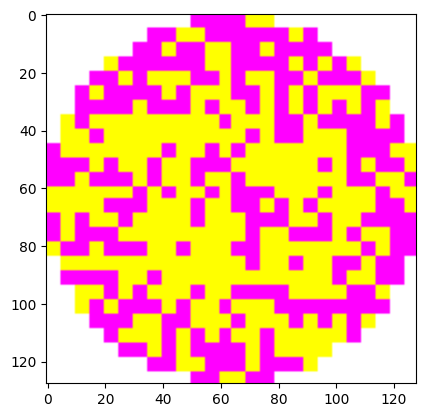

In [ ]:
import matplotlib.pyplot as plt

#첫번째 이미지 시각화

first_image = X[0]
print(first_image.shape)
plt.imshow(first_image)
plt.show()

In [ ]:
first_image.flatten().shape

(49152,)

In [ ]:
# 첫번째 이미지를 flatten 시켜서 출력 128*128*3 = 49152
flattened = first_image.flatten()
print(flattened)
flattened.shape

[255 255 255 ... 255 255 255]


(49152,)

In [ ]:
# 유니크한 각 픽셀의 개수
unique_elements, counts = np.unique(flattened, return_counts=True)
print(dict(zip(unique_elements, counts)))

{0: 12998, 255: 36154}


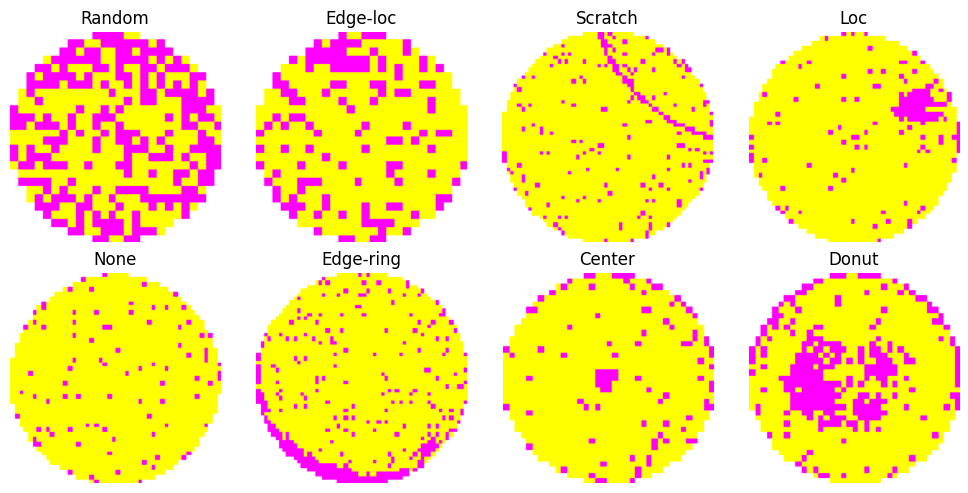

In [ ]:
import matplotlib.pyplot as plt

# 클래스별로 이미지 하나씩 시각화
num_classes = len(categories)

# 각 클래스의 첫 번째 이미지 인덱스 찾기
class_first_indices = [np.where(Y == i)[0][0] for i in range(num_classes)]

# 이미지 출력 설정
plt.figure(figsize=(10, 5))
for i, idx in enumerate(class_first_indices):
    plt.subplot(2, 4, i + 1)  # 2행 4열의 subplot을 만들고 각 클래스별 이미지 출력
    plt.imshow(X[idx])
    plt.title(categories[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 및 테스트 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
# 훈련데이터에서 검증 데이터 추출
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train)


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (512, 128, 128, 3)
y_train shape: (512,)
x_valid shape: (128, 128, 128, 3)
y_valid shape: (128,)
x_test shape: (160, 128, 128, 3)
y_test shape: (160,)


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 데이터 증강 정의 (학습 데이터셋에만 적용)

# 증강 확률의 기본값은 0.5
train_transform = transforms.Compose([
      transforms.ToPILImage(),
#      transforms.RandomVerticalFlip(p=0.99), # 상하 반전
#      transforms.RandomHorizontalFlip(), # 좌우 반전
#      transforms.RandomRotation(90), #  (-degree, +degree) 사이만큼 회전
#      transforms.RandomGrayscale(), # 흑백화
    transforms.ToTensor(), #  0 ~ 1 범위로 변환
   # transforms.RandomErasing(), # 랜덤으로 사각형을 만들어 지움
])

# 검증 및 테스트 데이터셋에는 증강 적용 안 함
test_transform = transforms.Compose([
   transforms.ToTensor(), #  0 ~ 1 범위로 변환
])


class CustomDataset(Dataset):
    def __init__(self, X, y, mode='train'):  # mode 인자 추가
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
        self.mode = mode  # mode 저장

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.mode == 'train':
            x = train_transform(x)
        else:  # 'valid' 또는 'test'
            x = test_transform(x)
        y = self.y[idx]
        return x, y

# Dataset 생성
train_dataset = CustomDataset(x_train, y_train, mode='train')
valid_dataset = CustomDataset(x_valid, y_valid, mode='valid')
test_dataset = CustomDataset(x_test, y_test, mode='test')
# DataLoader 정의

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True) # 학습 로더에서 나오는 데이터는 항상 섞어줍니다
# train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True) # drop_last: 데이터 수가 배치 사이즈로 나누어 떨어지지 않을 때, 마지막 배치는 버리는 옵션
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False) # 평가를 위해서 순차적으로 나오게 합니다
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False) # 평가를 위해서 순차적으로 나오게 합니다

In [ ]:
print("train dataset의 샘플수와 총 배치의 개수: ", len(train_dataset),len(train_loader))
print("valid dataset의 샘플수와 총 배치의 개수 ", len(valid_dataset),len(valid_loader))
print("test dataset의 샘플수와 총 배치의 개수: ", len(test_dataset),len(test_loader))

train dataset의 샘플수와 총 배치의 개수:  512 32
valid dataset의 샘플수와 총 배치의 개수  128 8
test dataset의 샘플수와 총 배치의 개수:  160 10


In [ ]:
# 첫번째 이미지의 shape 및 레이블 확인
# 항상 채널, 높이, 너비 순서를 가져야함
print(train_dataset[0][0].shape,train_dataset[0][1])

torch.Size([3, 128, 128]) tensor(0)


In [ ]:
# loader에서 데이터가 어떻게 나오는지 확인

for i, (images, labels) in enumerate(train_loader):
    print(f"train batch {i}: {images.shape}")
print()
for i, (images, labels) in enumerate(valid_loader):
    print(f"valid batch {i}: {images.shape}")
   # print(labels)
print()
for i, (images, labels) in enumerate(test_loader):
    print(f"test batch {i}: {images.shape}")

train batch 0: torch.Size([16, 3, 128, 128])
train batch 1: torch.Size([16, 3, 128, 128])
train batch 2: torch.Size([16, 3, 128, 128])
train batch 3: torch.Size([16, 3, 128, 128])
train batch 4: torch.Size([16, 3, 128, 128])
train batch 5: torch.Size([16, 3, 128, 128])
train batch 6: torch.Size([16, 3, 128, 128])
train batch 7: torch.Size([16, 3, 128, 128])
train batch 8: torch.Size([16, 3, 128, 128])
train batch 9: torch.Size([16, 3, 128, 128])
train batch 10: torch.Size([16, 3, 128, 128])
train batch 11: torch.Size([16, 3, 128, 128])
train batch 12: torch.Size([16, 3, 128, 128])
train batch 13: torch.Size([16, 3, 128, 128])
train batch 14: torch.Size([16, 3, 128, 128])
train batch 15: torch.Size([16, 3, 128, 128])
train batch 16: torch.Size([16, 3, 128, 128])
train batch 17: torch.Size([16, 3, 128, 128])
train batch 18: torch.Size([16, 3, 128, 128])
train batch 19: torch.Size([16, 3, 128, 128])
train batch 20: torch.Size([16, 3, 128, 128])
train batch 21: torch.Size([16, 3, 128, 128]

train batch 0: torch.Size([16, 3, 128, 128])
tensor([3, 4, 7, 0, 2, 7, 0, 4, 3, 0, 6, 4, 6, 2, 3, 2])


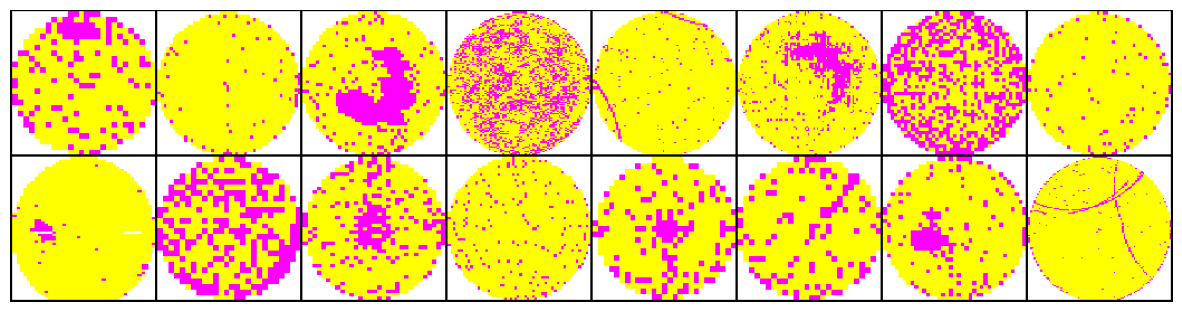

In [ ]:
import torchvision

# 첫 번째 배치 데이터 가져오기
for i, (images, labels) in enumerate(train_loader):
    print(f"train batch {i}: {images.shape}")
    break

# Figure 크기 설정
plt.figure(figsize=(15, 10))
print(labels)
# 이미지 시각화
img_grid = torchvision.utils.make_grid(images)
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### 2) 모델 만들기  

# Convolutional Neural Network, CNN
* convolution
* ReLU
* pooling


![alt text](https://mukulrathi.com/aad8a78e265cb76c3b0ebe17a058b19c/conv-slide.gif)
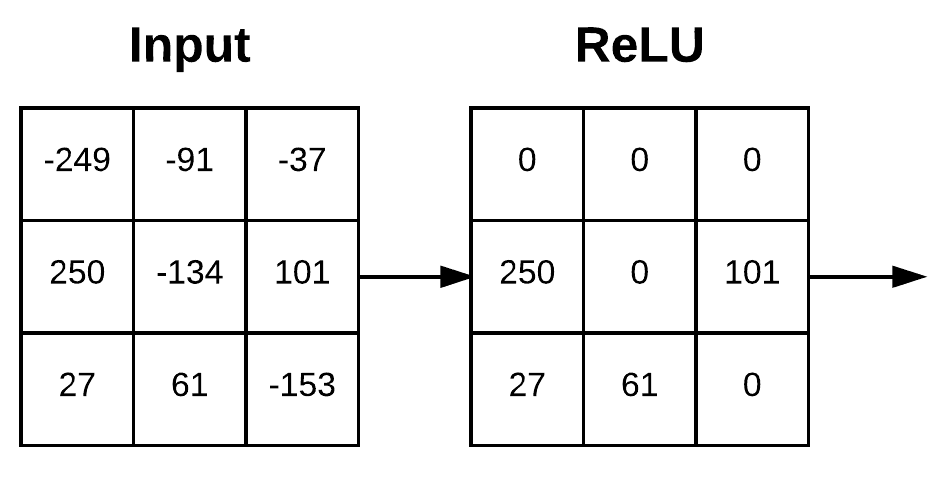
![alt text](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

In [ ]:
# import torch.nn as nn
# import torch.nn.init as init

# class CNN(nn.Module):
#     def __init__(self, n_channels=3, n_classes=8, init_weights=False):
#         super().__init__()

#         # 첫 번째 레이어 (입력 채널 수, 출력 채널 수, 커널 크기, 패딩)
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(n_channels, 32, kernel_size=3, padding=1),  # 입력: (3, 128, 128), 출력: (32, 128, 128)
#            # nn.BatchNorm2d(32),                                    # 배치 정규화
#             nn.ReLU(),                                            # 활성화 함수 ReLU 적용
#             nn.MaxPool2d(kernel_size=2, stride=2)                 # 풀링: (32, 64, 64)
#         )

#         # 두 번째 레이어
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),           # 입력: (32, 64, 64), 출력: (64, 64, 64)
#            # nn.BatchNorm2d(64),                                    # 배치 정규화
#             nn.ReLU(),                                            # 활성화 함수 ReLU 적용
#             nn.MaxPool2d(kernel_size=2, stride=2)                 # 풀링: (64, 32, 32)
#         )

#         # 세 번째 레이어
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),          # 입력: (64, 32, 32), 출력: (128, 32, 32)
#           #  nn.BatchNorm2d(128),                                    # 배치 정규화
#             nn.ReLU(),                                            # 활성화 함수 ReLU 적용
#             nn.MaxPool2d(kernel_size=2, stride=2)                 # 풀링: (128, 16, 16)
#         )

#         # 네 번째 레이어
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),         # 입력: (128, 16, 16), 출력: (256, 16, 16)
#           #  nn.BatchNorm2d(256),                                    # 배치 정규화
#             nn.ReLU(),                                            # 활성화 함수 ReLU 적용
#             nn.MaxPool2d(kernel_size=2, stride=2)                 # 풀링: (256, 8, 8)
#         )

#         self.classifier = nn.Sequential(
#                 nn.Linear(256 * 8 * 8, 1024),  # 256 * 8 * 8: 마지막 Conv 레이어의 출력 (flatten한 것)을 1024개 피쳐로
#                 nn.ReLU(),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(1024, n_classes), # 1024개 feature를 8개의 클래스로 매핑
#             )

#         # init_weights가 True인 경우 가중치 초기화
#         if init_weights:
#             self.initialize_weights()

#     def initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 init.constant_(m.weight, 1)
#                 init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 init.normal_(m.weight, 0, 0.01)
#                 init.constant_(m.bias, 0)


#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = out.view(out.size(0), -1)  #  torch.Size([16, 256, 8, 8])  ->  torch.Size([16, 16384])
#         out = self.classifier(out)
#         return out


In [ ]:
import torch.nn as nn
import torch.nn.init as init

class CNN(nn.Module):
    def __init__(self, n_channels=3, n_classes=8, init_weights=False):
    # def __init__(self, n_channels=3, n_classes=8, init_weights=True):
        super().__init__()

        # 첫 번째 레이어 (입력 채널 수, 출력 채널 수, 커널 크기, 패딩)
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=3, padding=1),  # 입력: (3, 128, 128), 출력: (16, 128, 128)
            nn.BatchNorm2d(16),                                    # 배치 정규화
            nn.ReLU(),                                            # 활성화 함수 ReLU 적용
            nn.MaxPool2d(kernel_size=2, stride=2)                 # 풀링: (16, 64, 64)
        )

        # 두 번째 레이어
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),           # 입력: (16, 64, 64), 출력: (32, 64, 64)
            nn.BatchNorm2d(32),                                    # 배치 정규화
            nn.ReLU(),                                            # 활성화 함수 ReLU 적용
            nn.MaxPool2d(kernel_size=2, stride=2)                 # 풀링: (32, 32, 32)
        )

        # 세 번째 레이어
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),          # 입력: (32, 32, 32), 출력: (64, 32, 32)
            nn.BatchNorm2d(64),                                    # 배치 정규화
            nn.ReLU(),                                            # 활성화 함수 ReLU 적용
            nn.MaxPool2d(kernel_size=2, stride=2),                 # 풀링: (64, 16, 16)
            nn.Dropout(p=0.5)
        )

        self.classifier = nn.Sequential(
                nn.Linear(64 * 16 * 16, 1024),  # 256 * 8 * 8: 마지막 Conv 레이어의 출력 (flatten한 것)을 1024개 피쳐로
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(1024, n_classes), # 1024개 feature를 8개의 클래스로 매핑
            )

        # init_weights가 True인 경우 가중치 초기화
        if init_weights:
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [ ]:
# 모델 생성
# model = CNN(n_channels=3, n_classes=8, init_weights=False).to(device)
model = CNN(n_channels=3, n_classes=8, init_weights=True).to(device)

#### 3) 학습

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

In [ ]:
class EarlyStopping:
    """
    조기 종료(Early Stopping) 클래스: 특정 에폭 동안 손실(loss)이 개선되지 않으면 훈련 중단
    """

    def __init__(self, patience=3, min_delta=0):
        """
        초기화 함수: patience, min_delta 값을 설정하고 카운터, best_loss를 초기화

        min_delta (float): 새로운 손실이 이전 손실보다 개선되었다고 간주하기 위한 최소 차이
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        """
         검증 손실(val_loss)을 받아 조기 종료 여부를 결정

        Returns:
            bool: 조기 종료해야 하는 경우 True, 계속 훈련해야 하는 경우 False
        """
        if self.best_loss is None:  # 첫 번째 에폭인 경우 best_loss 설정
            self.best_loss = val_loss

        elif self.best_loss - val_loss > self.min_delta:  # 손실이 충분히 개선된 경우
            self.best_loss = val_loss
            self.counter = 0  # 카운터 초기화

        else:  # 손실이 개선되지 않은 경우
            self.counter += 1

            if self.counter >= self.patience:  # patience 만큼 손실이 개선되지 않으면
                print("[INFO] Early stopping")  # 조기 종료 메시지 출력
                return True  # 조기 종료 신호 반환

        return False  # 계속 훈련 신호 반환

In [ ]:
import torch

class LRScheduler():
    """
    학습률 스케줄러. 주어진 `patience` 에포크 동안 검증 손실이 감소하지 않으면
    학습률을 주어진 `factor`만큼 감소.
    """
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5, verbose=True):
        """
        new_lr = old_lr * factor
        :param optimizer: 사용할 옵티마이저
        :param patience: 학습률을 업데이트하기 전에 기다릴 에포크 수
        :param min_lr: 학습률이 감소할 수 있는 최소 값
        :param factor: 학습률을 감소시킬 비율
        :param verbose: 학습률이 조정될 때 메시지를 출력할지 여부
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.verbose = verbose

        # ReduceLROnPlateau 스케줄러 사용
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=self.verbose
        )

    def __call__(self, val_loss):
        """
        검증 손실을 기준으로 학습률을 조정합니다.
        :param val_loss: 현재 검증 손실 값
        """
        self.lr_scheduler.step(val_loss)


In [ ]:
import torch


def train(model, train_loader, optimizer, criterion, device):

    # 모델을 학습 모드로 설정
    model.train()
    # loss 누적값 초기화
    running_loss = 0.0
    for inputs, labels in train_loader: # 로더에서 배치 사이즈만큼 데이터와 레이블 랜덤 추출
        inputs, labels = inputs.to(device), labels.to(device) # device로 옮기기

        # 기울기 초기화
        optimizer.zero_grad()

        outputs = model(inputs) # 모델에 인풋데이터 입력하여 아웃풋 추출

        loss = criterion(outputs, labels) # 아웃풋과 레이블과의 loss 계산

        loss.backward() # 파라미터에 대한 loss 기울기 계산
        optimizer.step() # 파라미터 업데이트

        # loss 누적
        running_loss += loss.item() * inputs.size(0)

        # 평균 loss 반환
    return running_loss / len(train_loader.dataset)

# 평가 함수 정의
def evaluate(model, loader, criterion, device):
    # 모델을 평가 모드로 설정
    model.eval()
    running_loss = 0.0

    # 정확하게 예측된 샘플 수를 초기화
    correct_preds = 0
    # 모든 예측과 실제 레이블을 저장할 리스트를 초기화
    all_preds = []
    all_labels = []

    # 기울기를 계산하지 않도록 torch.no_grad() 내에서 연산 수행
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # 예측된 클래스를 가져와 정확하게 예측된 샘플 수를 누적
            _, predicted = torch.max(outputs, 1)
            correct_preds += torch.sum(predicted == labels).item()

            # 예측 결과와 실제 레이블을 리스트에 추가
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 전체 데이터셋에 대한 평균 손실을 계산
    avg_loss = running_loss / len(loader.dataset)
    # 정확도를 계산
    accuracy = correct_preds / len(loader.dataset)
    # 평균 손실, 정확도, 예측된 값들, 실제 레이블들을 반환
    return avg_loss, accuracy, all_preds, all_labels


In [ ]:
# from utils.EarlyStopping      import *
# from utils.LRScheduler        import *
# from utils.train_eval_util import train, evaluate


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr     = args.learning_rate)


early_stopping = EarlyStopping(patience  = 100,
                               min_delta = 1e-5)


scheduler = LRScheduler(optimizer = optimizer,
                        patience  = 50,
                        min_lr    = 1e-10,
                        factor    = 0.5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_losses = []
valid_losses = []
best_valid_loss = float(np.inf) # best validation loss는 infinity로 초기화

for epoch in range(args.epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch [{epoch+1}/{args.epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + args.model_name + ".pth")

Epoch [1/50], Train Loss: 1.7126, Valid Loss: 1.2161, Valid Acc: 0.6875
Epoch [2/50], Train Loss: 1.0203, Valid Loss: 0.7149, Valid Acc: 0.7891
Epoch [3/50], Train Loss: 0.6754, Valid Loss: 0.5787, Valid Acc: 0.7812
Epoch [4/50], Train Loss: 0.5982, Valid Loss: 0.6242, Valid Acc: 0.7266
Epoch [5/50], Train Loss: 0.4994, Valid Loss: 0.5934, Valid Acc: 0.7969
Epoch [6/50], Train Loss: 0.3842, Valid Loss: 0.4681, Valid Acc: 0.8359
Epoch [7/50], Train Loss: 0.3411, Valid Loss: 0.4379, Valid Acc: 0.8438
Epoch [8/50], Train Loss: 0.3049, Valid Loss: 0.4654, Valid Acc: 0.8281
Epoch [9/50], Train Loss: 0.2458, Valid Loss: 0.4769, Valid Acc: 0.7891
Epoch [10/50], Train Loss: 0.1904, Valid Loss: 0.4190, Valid Acc: 0.8516
Epoch [11/50], Train Loss: 0.1633, Valid Loss: 0.3785, Valid Acc: 0.8516
Epoch [12/50], Train Loss: 0.1190, Valid Loss: 0.3678, Valid Acc: 0.8672
Epoch [13/50], Train Loss: 0.0855, Valid Loss: 0.3591, Valid Acc: 0.8438
Epoch [14/50], Train Loss: 0.0878, Valid Loss: 0.3814, Valid

In [ ]:
# 저장된 모델 로드

model.load_state_dict( torch.load( "./" + args.model_name + ".pth" ) )

# 테스트 세트 평가
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.5416, Test Acc: 0.8562


<ipython-input-281-f03b9ba8a060>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load( "./" + args.model_name + ".pth" ) )


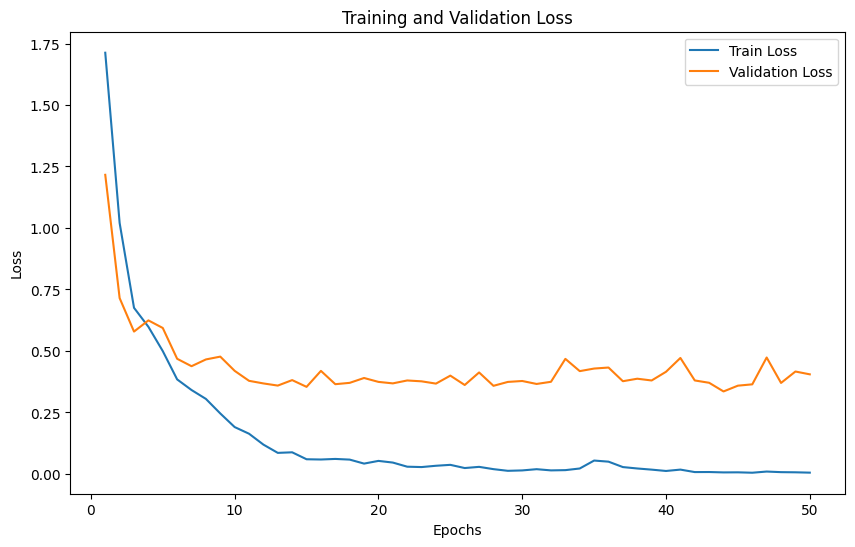

In [ ]:
import matplotlib.pyplot as plt

# Train vs Validation Loss 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

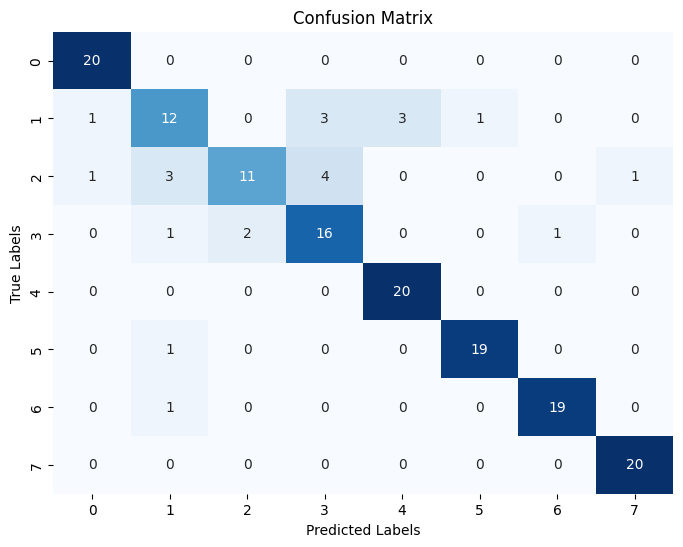

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
conf_matrix = confusion_matrix(test_labels, test_preds)
# Confusion Matrix 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 첫 번째 배치 데이터 가져오기
for i, (images, _) in enumerate(test_loader):
    print(f"train batch {i}: {images.shape}")
    break


train batch 0: torch.Size([16, 3, 128, 128])


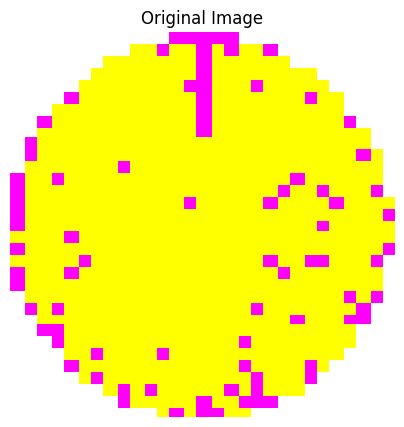

torch.Size([16, 16, 64, 64])


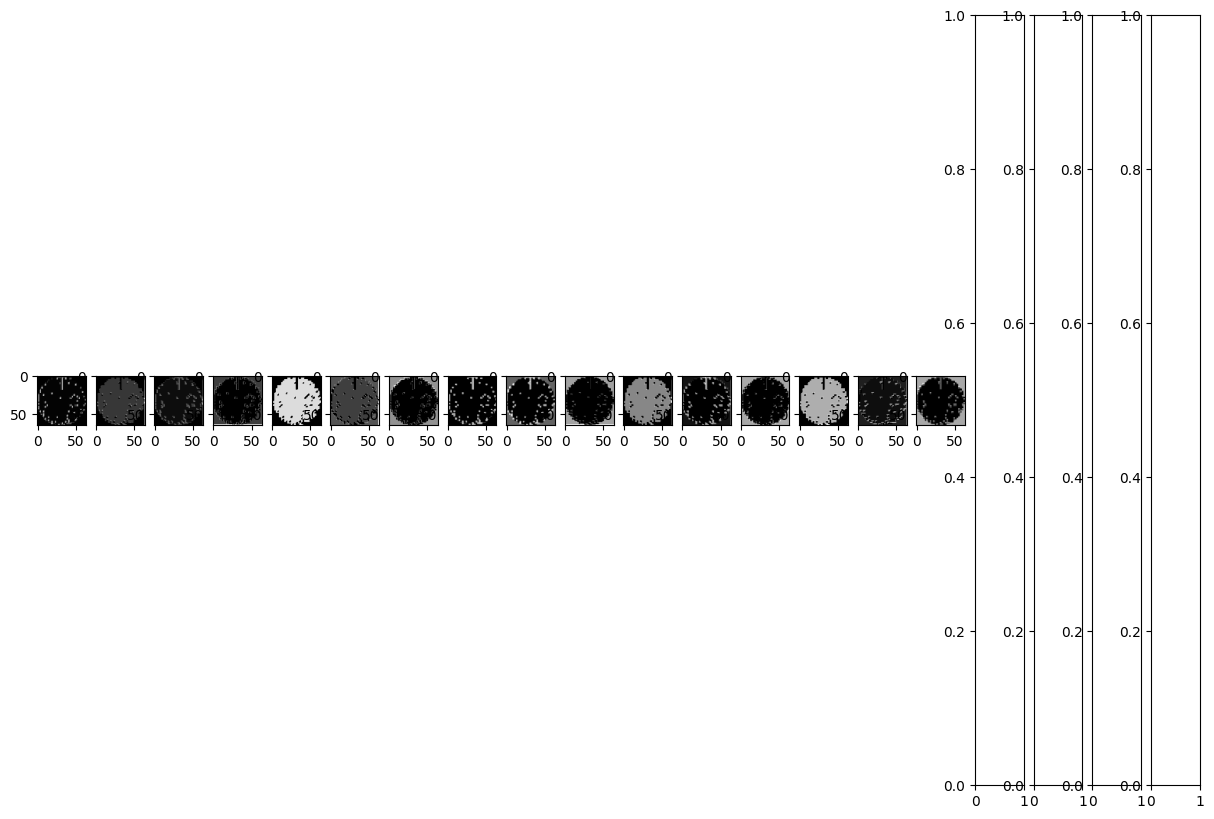

torch.Size([16, 32, 32, 32])


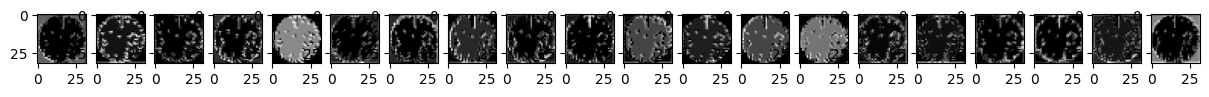

torch.Size([16, 64, 16, 16])


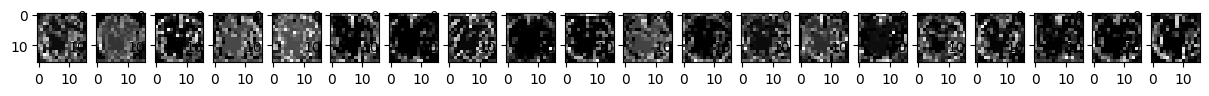

In [ ]:
# 특징맵 시각화
images_np = images.cpu().numpy()
plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(images_np[0], (1, 2, 0)))
plt.title('Original Image')
plt.axis('off')
plt.show()

with torch.no_grad():
    layer_outputs = []
    x = images.to(device)
    for layer in [model.layer1, model.layer2, model.layer3]:
        x = layer(x)
        layer_outputs.append(x)


num_feature_maps_to_display = 20

for i, output in enumerate(layer_outputs):
    num_features = output.shape[1]
    print(output.shape)
    fig, axes = plt.subplots(1, num_feature_maps_to_display, figsize=(15, 10))

    for j in range(num_feature_maps_to_display):
        if j < num_features:
            axes[j].imshow(output[0, j].cpu(),cmap='gray')
    plt.show()

In [ ]:
# 마지막 block에서 나온 feature를 flatten
last_features = output.view(output.shape[0], -1)
last_features.shape

torch.Size([16, 16384])

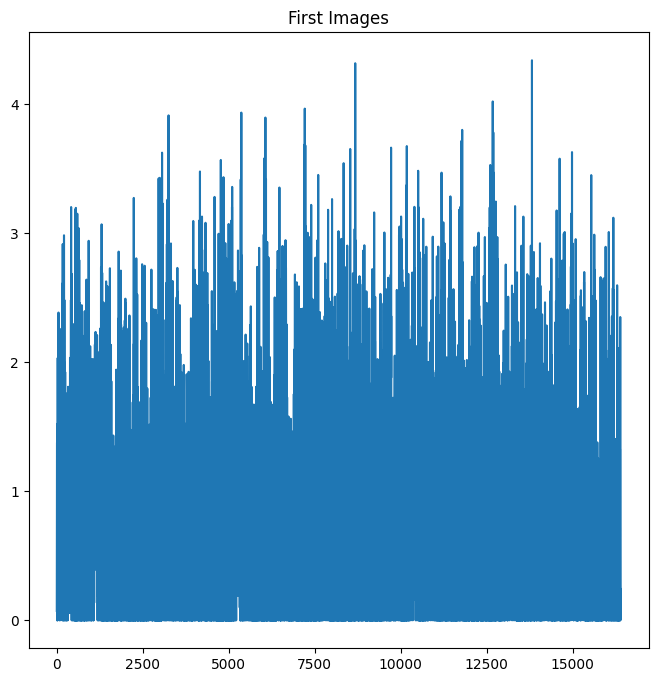

In [ ]:
first_image_features = last_features[0, :]  # 배치에서 첫 번째 샘플만 선택

# 시각화를 위해 이미지 플롯
plt.figure(figsize=(8, 8))
plt.plot(first_image_features.cpu().numpy())
plt.title('First Images')
plt.show()